In [3]:
import gspa
import scprep
import scanpy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import phate
import seaborn as sns
import magic, meld
from collections import defaultdict
import leidenalg

## Load data (manuscript in progress with collaborators) & visualize samples and annotated cell types
### NO_AG: no antigen
### AG: antigen
### AG+CPI: antigen with checkpoint inhibitors

In [10]:
adata = scanpy.read_h5ad('./data/skin_processed_human_name.h5ad')
adata.obs['samples'] = [x[:-2] for x in adata.obs.sample_labels]
adata.var_names = adata.var.symbol

/gpfs/gibbs/project/krishnaswamy_smita/av622/conda_envs/gspa/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/gpfs/gibbs/project/krishnaswamy_smita/av622/conda_envs/gspa/lib/python3.8/site-packages/anndata/_core/anndata.py:895: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    ['0610009B22Rik', '0610010K14Rik', '0610012G03Rik', '0610030E20Rik', '0610040J01Rik']

    Inferred to be: categorical

  names = self._prep_dim_index(names, "var")


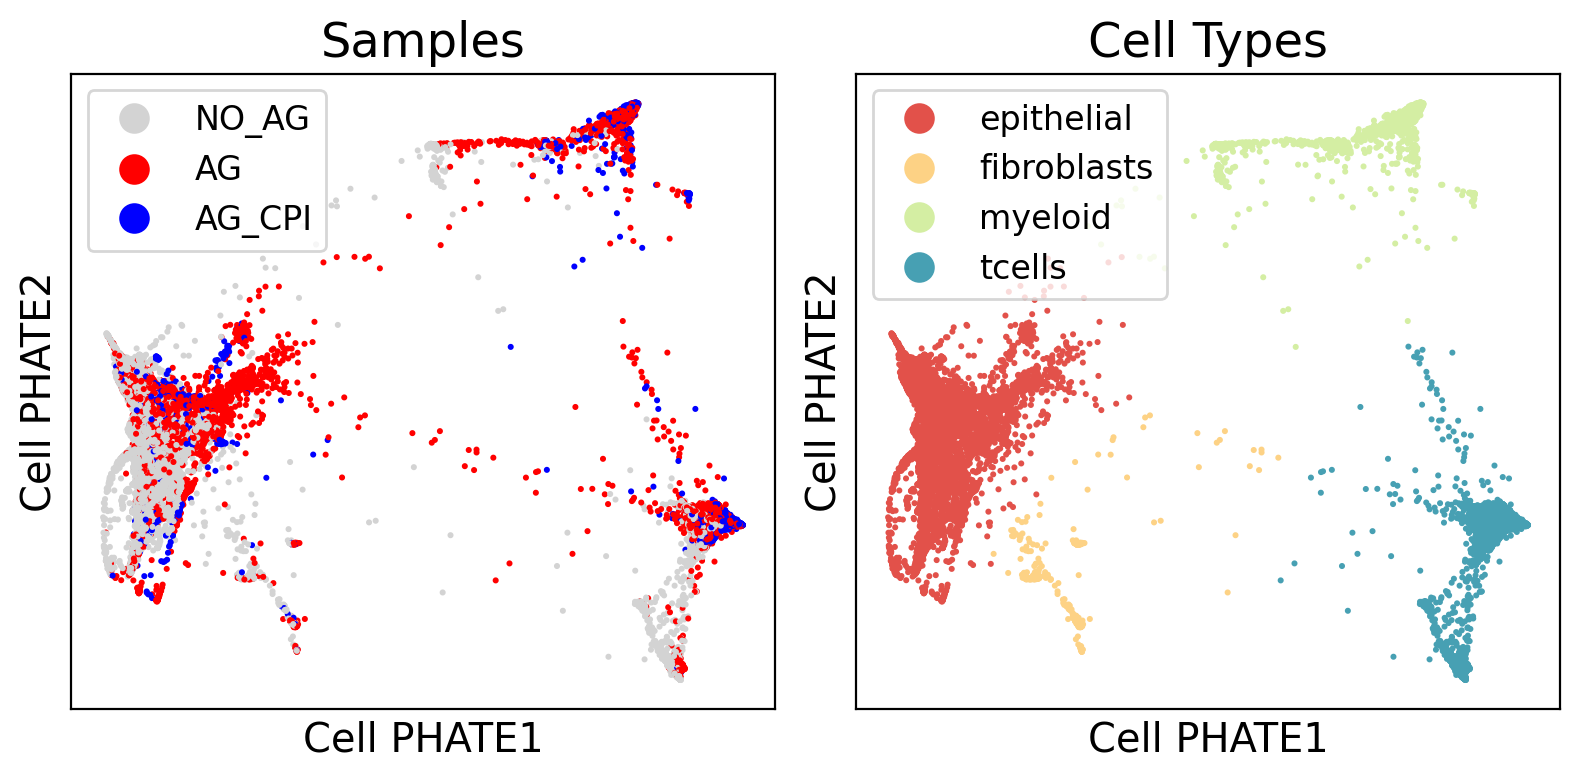

In [11]:
fig, ax = plt.subplots(1,2, figsize=(8,4), dpi=200); ax=ax.flatten()
scprep.plot.scatter2d(adata.obsm['X_PHATE'], c=adata.obs.samples, figsize=(4.3,3),
                     title=f'Samples', label_prefix='Cell PHATE', ticks=None, ax=ax[0],
                     cmap={'NO_AG': 'lightgray', 'AG':'red', 'AG_CPI':'blue'})

scprep.plot.scatter2d(adata.obsm['X_PHATE'], c=adata.obs.cell_types, figsize=(4.3,3),
                     title=f'Cell Types', label_prefix='Cell PHATE', ticks=None, ax=ax[1],
                     cmap=sns.color_palette('Spectral')[:10])

plt.tight_layout()
fig.savefig('./figures/samples_cell_types.png', dpi=200)

In [12]:
phate_op = phate.PHATE(random_state=42, knn=40, decay=10, use_pygsp=True)
phate_op.fit(adata.obsm['X_PCA'])

Running PHATE on 21178 observations and 100 variables.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculated KNN search in 49.30 seconds.
  Calculating affinities...
  Calculated affinities in 62.62 seconds.
Calculated graph and diffusion operator in 121.35 seconds.
Calculating landmark operator...
  Calculating SVD...
  Calculated SVD in 35.02 seconds.
  Calculating KMeans...
  Calculated KMeans in 4.33 seconds.
Calculated landmark operator in 42.90 seconds.


PHATE(decay=10, knn=40, random_state=42)

In [13]:
G = phate_op.graph
del(phate_op) ## save memory by deleting large objects

## Get highly variable genes

In [14]:
hvgs = np.array(adata[:, adata.var.hvg].var.symbol)

## Extract ligand-receptor pairs that are highly and variably expressed from CellChat

In [15]:
signaling_pathways = pd.read_csv('./data/cellchat.csv')[['interaction.pathway_name', 'interaction.interaction_name_2', 'interaction.annotation']]
ligand = [x.split(' - ')[0].strip() for x in signaling_pathways['interaction.interaction_name_2']]
receptors = [x.split(' - ')[1][1:-1].strip().split('+') if '+' in x else x.split(' - ')[1].strip().split('+') for x in signaling_pathways['interaction.interaction_name_2']]

signaling_pathways['ligand'] = ligand
signaling_pathways['receptors'] = receptors

r = []
for row in signaling_pathways.iterrows():
    for receptor in row[1]['receptors']:
        r.append([row[1]['interaction.pathway_name'], row[1]['ligand'], receptor, row[1]['interaction.annotation']])
        
signaling_pathways = pd.DataFrame(r, columns=['pathway', 'ligand', 'receptor', 'interaction']).drop_duplicates()
signaling_pathways_hvgs = signaling_pathways[(signaling_pathways['ligand'].isin(hvgs)) & (signaling_pathways['receptor'].isin(hvgs))]

In [16]:
num_pairs = signaling_pathways_hvgs.shape[0]
signaling_pathways_hvgs.index = range(num_pairs) ## unique pairs where ligand and receptor are both HVGs

In [17]:
data = adata.to_df().loc[:, ~adata.to_df().columns.duplicated()]

## Learn gene embedding

## Learn ligand-receptor embedding

In [24]:
ligands = data[signaling_pathways_hvgs['ligand']].T
receptors = data[signaling_pathways_hvgs['receptor']].T

In [ ]:
gspa_op = gspa.GSPA(graph=G)
gspa_op.build_diffusion_operator()
gspa_op.build_wavelet_dictionary()

In [ ]:
ligands_reduced = gspa.embedding.svd(gspa.embedding.project(ligands, gspa_op.wavelet_dictionary))
receptors_reduced = gspa.embedding.svd(gspa.embedding.project(receptors, gspa_op.wavelet_dictionary))

In [222]:
np.save('./results/ligand_embedding.npy', ligands_reduced)
np.save('./results/receptor_embedding.npy', receptors_reduced)

In [25]:
signaling_pathways_hvgs.to_csv('results/LR_signaling_clusters.csv')

,pathway,ligand,receptor,interaction
0,TGFb,Tgfb1,Tgfbr1,Secreted Signaling
1,TGFb,Tgfb1,Tgfbr2,Secreted Signaling
2,GDF,Gdf11,Tgfbr1,Secreted Signaling
3,WNT,Wnt10a,Fzd2,Secreted Signaling
4,WNT,Wnt10b,Fzd2,Secreted Signaling
...,...,...,...,...
356,THY1,Thy1,Itgb3,Cell-Cell Contact
357,TIGIT,Tigit,Pvr,Cell-Cell Contact
358,VCAM,Vcam1,Itga4,Cell-Cell Contact
359,VCAM,Vcam1,Itgb1,Cell-Cell Contact
